## consider the model proposed in the paper, which is a further simplified version of an ordinary simplified OT

In [1]:
import numpy as np
from mip import Model, xsum, minimize, maximize, OptimizationStatus
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from numpy.linalg import inv
import time
from scipy.stats import norm

EXP_TIMES = 100
TIME_LEVELS = 50
SAMPLE_AMOUNT = 100
SIGMA = 0.5

collection = np.zeros(EXP_TIMES)

start_time = time.time()

for exp in range(EXP_TIMES):
    # generate
    X10 = np.array([1.0]*SAMPLE_AMOUNT)
    X11 = np.random.randint(2,size=SAMPLE_AMOUNT).astype(float)
    X12 = np.random.uniform(0,3,SAMPLE_AMOUNT)
    X13 = np.random.normal(0, 1/4, SAMPLE_AMOUNT)
    
    X21_latent = np.random.normal(0, 1/4, SAMPLE_AMOUNT)
    X22 = np.random.normal(0, 1/4, SAMPLE_AMOUNT)
    X21 = X21_latent + 1/2 * X22
    X21_and_22 = np.column_stack((X21, X22))
    
    
    EPSI1_latent = np.random.uniform(0,1,SAMPLE_AMOUNT)
    EPSI2_latent = np.random.uniform(0,1,SAMPLE_AMOUNT)
    
    Y1_latent_fix = 2 * X10 + 3 * X11 + X12
    Y2_latent_fix =     X10 + 2 * X11 + X13
    
    # A is a matrix 
    #  [ 1/2, 1/2 ]
    #  [   0, 1/2 ]
    
    EPSI1_transed = 1/2 * EPSI1_latent + 1/2 * EPSI2_latent
    EPSI2_transed = 1/2 * EPSI2_latent
    
    EPSI1 = norm.ppf(EPSI1_transed, loc=0, scale=SIGMA)
    EPSI2 = norm.ppf(EPSI2_transed, loc=0, scale=SIGMA)
    
    Y1_latent = Y1_latent_fix + EPSI1
    Y2_latent = Y2_latent_fix + EPSI2
    
    Y1 = 1/2 * Y1_latent
    Y2 = 1/2 * Y1_latent + 1/2 * Y2_latent 
    
    # wilcoxon scores, phi(t1, t2)= 1/2(t1 + t2) - 1/2
    
    A2 = 1/24
    
    
    Q = 1/SAMPLE_AMOUNT * np.matmul(X21_and_22.T,X21_and_22)
    
    dual_density = np.zeros((TIME_LEVELS, TIME_LEVELS, SAMPLE_AMOUNT))
    
    m = Model()
    
    pi = [[[m.add_var(lb=0,name="pi") for i in range(SAMPLE_AMOUNT)] for t2 in range(TIME_LEVELS)] for t2 in range(TIME_LEVELS)]
    
    for t1 in range(TIME_LEVELS):
        for t2 in range(TIME_LEVELS):
            
            m += xsum(pi[t1][t2][i]*X10[i] for i in range(SAMPLE_AMOUNT)) == xsum(X10[i] for i in range(SAMPLE_AMOUNT))/TIME_LEVELS**2
            m += xsum(pi[t1][t2][i]*X11[i] for i in range(SAMPLE_AMOUNT)) == xsum(X11[i] for i in range(SAMPLE_AMOUNT))/TIME_LEVELS**2
            m += xsum(pi[t1][t2][i]*X12[i] for i in range(SAMPLE_AMOUNT)) == xsum(X12[i] for i in range(SAMPLE_AMOUNT))/TIME_LEVELS**2
            m += xsum(pi[t1][t2][i]*X13[i] for i in range(SAMPLE_AMOUNT)) == xsum(X13[i] for i in range(SAMPLE_AMOUNT))/TIME_LEVELS**2
        
    for i in range(SAMPLE_AMOUNT):
        m += xsum(xsum(pi[t1][t2][i] for t1 in range(TIME_LEVELS)) for t2 in range(TIME_LEVELS)) == 1
        
    m.objective = maximize(
        xsum(
            xsum(
                xsum(
                    (t1/TIME_LEVELS * Y1[i] + t2/TIME_LEVELS * Y2[i] * pi[t1-1][t2-1][i]) for i in range(SAMPLE_AMOUNT)
                ) for t2 in range(1,TIME_LEVELS+1)
            )for t1 in range(1,TIME_LEVELS+1)
        )
    )
    
    status = m.optimize(max_seconds=600)
    
    print("calculation ",exp)
    print(time.time()-start_time)
    
    if not status == OptimizationStatus.OPTIMAL:
        print("SOMETHING WRONG!")
        break

    else:
        t1=0
        t2=0
        i=0
        for v in m.vars: 
            dual_density[t1][t2][i] = v.x
            i+=1
            if i == SAMPLE_AMOUNT:
                i=0
                t2+=1
            if t2 == TIME_LEVELS:
                t2=0
                t1+=1
    
    # calculate target statistics
    
    b=0

    for t1 in range(1,TIME_LEVELS+1):
        for t2 in range(1,TIME_LEVELS+1):
            b += 1/2 * (t1/TIME_LEVELS + t2/TIME_LEVELS - 1) * dual_density[t1-1][t2-1]
        
        
    
    S = 1/np.sqrt(SAMPLE_AMOUNT) * np.matmul(X21_and_22.T,b)

    
    T = np.matmul(np.matmul(S.T,inv(Q)),S)/A2
    
    collection[exp] = T
    
    print(T)



calculation  0
120.52860808372498
0.6865573401213779
calculation  1
312.8836269378662
0.05442786087638591
calculation  2
422.2659041881561
0.5141979307802217
calculation  3
541.2022511959076
0.09760542490887802
calculation  4
659.7331745624542
0.23900332019671602
calculation  5
773.124792098999
0.49412440412556086
calculation  6
967.2153005599976
1.7749629018035475
calculation  7
1189.6422398090363
1.8665593581595272
calculation  8
1309.0305767059326
0.6330658816689797
calculation  9
1442.9649760723114
2.840062340350568
calculation  10
1560.9432408809662
1.5388097999292198
calculation  11
1686.8387298583984
4.758052703115249
calculation  12
1815.7083141803741
0.03851387725152237
calculation  13
1951.0921320915222
4.004668275125598
calculation  14
2071.241266489029
1.1501074274050007
calculation  15
2205.3022859096527
0.20387042680648348
calculation  16
2320.371513605118
0.6159556027160283
calculation  17
2431.342762231827
2.8377856004733837
calculation  18
2562.0883977413177
0.20127107

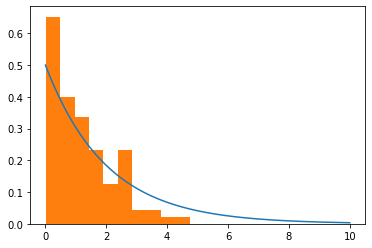

In [6]:
from scipy.stats import chi2

#x-axis ranges from 0 to 20 with .001 steps
x = np.arange(0, 10, 0.001)

#plot Chi-square distribution with 2 degrees of freedom
plt.plot(x, chi2.pdf(x, df=2))

plt.hist(collection, density=True, bins=10)

plt.show()

In [7]:
np.save("T_collection",collection)

## So it is good
## 0.1 -- 4.61
## 0.05 -- 5.99

## now about the alternative hypothesis

## this time we just test, for S, its expectation and variance

In [1]:
import numpy as np
from mip import Model, xsum, minimize, maximize, OptimizationStatus
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.linalg import sqrtm
import time
from scipy.stats import norm

EXP_TIMES = 100
TIME_LEVELS = 50
SAMPLE_AMOUNT = 100
SIGMA = 0.5

mean_collection = np.zeros((EXP_TIMES, 2))
var_collection = np.zeros((EXP_TIMES, 2))


start_time = time.time()

for exp in range(EXP_TIMES):
    # generate
    X10 = np.array([1.0]*SAMPLE_AMOUNT)
    X11 = np.random.normal(0, 1/4, SAMPLE_AMOUNT)
    
    X21_latent = np.random.normal(0, 1/4, SAMPLE_AMOUNT)
    X22 = np.random.normal(0, 1/4, SAMPLE_AMOUNT)
    X21 = X21_latent + 1/2 * X22
    X21_and_22 = np.column_stack((X21, X22))
    
    # B0 is a matrix 
    # [ 1/20, 1/30 ]
    # [   0,  1/10 ]
    
    
    EPSI1_latent = np.random.uniform(0,1,SAMPLE_AMOUNT)
    EPSI2_latent = np.random.uniform(0,1,SAMPLE_AMOUNT)
    
    Y1_latent_fix = 2 * X10 + 1/np.sqrt(SAMPLE_AMOUNT) * (1/20 * X21)
    Y2_latent_fix =     X10 + X11 + 1/np.sqrt(SAMPLE_AMOUNT) * (1/30 * X21 + 1/10 * X22)
    
    # A is a matrix 
    #  [ 1/2, 1/2 ]
    #  [   0, 1/2 ]
    
    EPSI1_transed = 1/2 * EPSI1_latent + 1/2 * EPSI2_latent
    EPSI2_transed = 1/2 * EPSI2_latent
    
    EPSI1 = norm.ppf(EPSI1_transed, loc=0, scale=SIGMA)
    EPSI2 = norm.ppf(EPSI2_transed, loc=0, scale=SIGMA)
    
    Y1_latent = Y1_latent_fix + EPSI1
    Y2_latent = Y2_latent_fix + EPSI2
    
    Y1 = 1/2 * Y1_latent
    Y2 = 1/2 * Y1_latent + 1/2 * Y2_latent
    
    # wilcoxon scores, phi(t1, t2)= 1/2(t1 + t2) - 1/2
    
    A2 = 1/24
    
    
    Q = 1/SAMPLE_AMOUNT * np.matmul(X21_and_22.T,X21_and_22)
    
    dual_density = np.zeros((TIME_LEVELS, TIME_LEVELS, SAMPLE_AMOUNT))
    
    m = Model()
    
    pi = [[[m.add_var(lb=0,name="pi") for i in range(SAMPLE_AMOUNT)] for t2 in range(TIME_LEVELS)] for t2 in range(TIME_LEVELS)]
    
    for t1 in range(TIME_LEVELS):
        for t2 in range(TIME_LEVELS):
            
            m += xsum(pi[t1][t2][i]*X10[i] for i in range(SAMPLE_AMOUNT)) == xsum(X10[i] for i in range(SAMPLE_AMOUNT))/TIME_LEVELS**2
            m += xsum(pi[t1][t2][i]*X11[i] for i in range(SAMPLE_AMOUNT)) == xsum(X11[i] for i in range(SAMPLE_AMOUNT))/TIME_LEVELS**2
            
    for i in range(SAMPLE_AMOUNT):
        m += xsum(xsum(pi[t1][t2][i] for t1 in range(TIME_LEVELS)) for t2 in range(TIME_LEVELS)) == 1
        
    m.objective = maximize(
        xsum(
            xsum(
                xsum(
                    (t1/TIME_LEVELS * Y1[i] + t2/TIME_LEVELS * Y2[i] * pi[t1-1][t2-1][i]) for i in range(SAMPLE_AMOUNT)
                ) for t2 in range(1,TIME_LEVELS+1)
            )for t1 in range(1,TIME_LEVELS+1)
        )
    )
    
    status = m.optimize(max_seconds=600)
    
    print("calculation ",exp)
    print(time.time()-start_time)
    
    if not status == OptimizationStatus.OPTIMAL:
        print("SOMETHING WRONG!")
        break

    else:
        t1=0
        t2=0
        i=0
        for v in m.vars: 
            dual_density[t1][t2][i] = v.x
            i+=1
            if i == SAMPLE_AMOUNT:
                i=0
                t2+=1
            if t2 == TIME_LEVELS:
                t2=0
                t1+=1
    
    # calculate target statistics
    
    b=0

    for t1 in range(1,TIME_LEVELS+1):
        for t2 in range(1,TIME_LEVELS+1):
            b += 1/2 * (t1/TIME_LEVELS + t2/TIME_LEVELS - 1) * dual_density[t1-1][t2-1]
        
        
    
    S = 1/np.sqrt(SAMPLE_AMOUNT) * np.matmul(X21_and_22.T,b)

    
    S_for_mean = np.matmul(inv(Q),S)
    
    S_for_var = np.matmul(sqrtm(inv(Q)),S)/np.sqrt(A2)
    
    mean_collection[exp] = S_for_mean
    var_collection[exp] = S_for_var


np.save("SMean_collection",mean_collection)
np.save("SVar_collection",var_collection)

calculation  0
32.619816064834595
calculation  1
63.300044775009155
calculation  2
92.54601669311523
calculation  3
123.89407658576965
calculation  4
152.02541184425354
calculation  5
178.5583872795105
calculation  6
211.44979453086853
calculation  7
238.67750883102417
calculation  8
264.8288276195526
calculation  9
297.2114288806915
calculation  10
325.68252778053284
calculation  11
353.1098601818085
calculation  12
383.3326606750488
calculation  13
411.9256408214569
calculation  14
439.0877513885498
calculation  15
470.3904025554657
calculation  16
499.74537348747253
calculation  17
528.5308492183685
calculation  18
560.9689002037048
calculation  19
589.5737197399139
calculation  20
617.6850433349609
calculation  21
645.5783324241638
calculation  22
673.972727060318
calculation  23
701.65496134758
calculation  24
743.4943838119507
calculation  25
771.7970767021179
calculation  26
798.1905887126923
calculation  27
828.3183801174164
calculation  28
857.5463528633118
calculation  29
890

## estimation effect

In [3]:
mean_vec = np.mean(var_collection, axis=0)
normed_var = var_collection - mean_vec
np.matmul(normed_var.T, normed_var)/SAMPLE_AMOUNT

array([[0.61521343, 0.015226  ],
       [0.015226  , 0.34088892]])

## estimate

In [5]:
# B0 is a matrix 
# [ 1/2, 1/3 ]
# [   0,   1 ]

MonteCarlo_amount = 100000
tau1 = np.random.uniform(0,1,MonteCarlo_amount)
tau2 = np.random.uniform(0,1,MonteCarlo_amount)

# A is a matrix 
#  [ 1/2, 1/2 ]
#  [   0, 1/2 ]

trans_tau1 = 1/2*tau1 + 1/2*tau2
trans_tau2 = 1/2*tau2

new_vecs = np.zeros((MonteCarlo_amount, 2))
for i in range(MonteCarlo_amount):
    A = np.array([[1/2, 1/2],[0, 1/2]])
    epsi_1 = 1/ (norm.pdf(norm.ppf(trans_tau1[i], loc=0, scale=SIGMA) ,loc=0, scale = SIGMA))
    epsi_2 = 1/ (norm.pdf(norm.ppf(trans_tau2[i], loc=0, scale=SIGMA) ,loc=0, scale = SIGMA))

    A[0] = epsi_1 * A[0]
    A[1] = epsi_2 * A[1]
    
    A_inv = inv(A)
    
    A_fin = np.matmul(A_inv, np.array([[1/2],[1/2]]))
    
    to_add = np.matmul(np.array([[1/20, 1/30],[0, 1/10]]),A_fin)
    
    new_vecs[i] = to_add.T[0]
    
print(np.mean(new_vecs, axis=0))


[0.02490623 0.05636023]
